In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from IPython.display import Audio

In [25]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

SAMPLING_RATE = 48_000 / 8

import sys
sys.path.append('../')
import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,happy,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.061167,2.701833,[5.9604645e-08 9.2448331e-02 7.0120022e-02 ......,[5.9604645e-08 9.2448264e-02 7.0119813e-02 ......,0,1304,2464,3832,4680,5664,6488,9840
1,speech,calm,strong,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.020167,2.983000,[3.3713877e-07 6.0990662e-03 8.3317356e-03 ......,[3.3713877e-07 6.0990625e-03 8.3317189e-03 ......,0,2112,5664,6304,6840,7704,9304,11776
2,speech,fearful,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.057000,2.642500,[4.5448542e-07 2.2871135e-02 2.1308422e-02 ......,[4.5448542e-07 2.2871116e-02 2.1308355e-02 ......,0,2032,3168,4648,5800,6728,7400,9512
3,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,928,1984,3232,4120,5120,5808,7352
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2104,3672,4808,5928,6944,7600,9056


In [27]:
## Import only the required stuff to prevent memory overload
traces_dict = dict()
for syll in [0,2]:
    file_path = os.path.join(TS_PREPROC_FOLDER, f"syllables_{syll}_ts.npy")
    traces_dict[f"syllables_{syll}_ts"] = np.load(file_path, allow_pickle=True)
# traces_dict["clean_trace"] = np.load( os.path.join(TS_PREPROC_FOLDER, "clean_trace.npy"), allow_pickle=True)
traces_dict.keys()

dict_keys(['syllables_0_ts', 'syllables_2_ts'])

In [28]:
traces_dict['syllables_0_ts'] = [ tr[~np.isnan(tr)] for tr in traces_dict['syllables_0_ts']]

Audio(syllables_0[0], rate=SAMPLING_RATE)

In [29]:
traces_dict['syllables_2_ts'] = [ tr[~np.isnan(tr)] for tr in traces_dict['syllables_2_ts']]

Audio(syllables_2[0], rate=SAMPLING_RATE)

In [36]:
# Concatenate syll0 and syll2
new_traces = [np.concatenate((traces_dict['syllables_0_ts'][i], traces_dict['syllables_2_ts'][i])) for i in range(len(syllables_0)) ]

Audio(new_traces[10], rate=SAMPLING_RATE)

1064


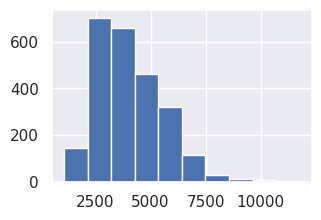

In [45]:
# Check distribution f lentgths
plt.hist([len(x) for x in new_traces]);
print(min([len(x) for x in new_traces]))

# Fourier stuff

In [127]:
from djanloo_fourier import STFTransformer

transf = STFTransformer(n_time_bins=None, 
                        n_spectral_bins=None, 
                        max_frequency=3000, 
                        sampling_rate=SAMPLING_RATE)

# Makes a square STFT
transf.balance_n_coeff(new_traces)
transf.report(new_traces)

Time bins = 23, Spectral bins = 23
min length of trace is roughly 46
max number of Fourier coeffs is 23


In [128]:
STFT = transf.fit_transform(new_traces)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2452/2452 [00:55<00:00, 43.79it/s]


Text(0.5, 1.0, 'statement = dogs')

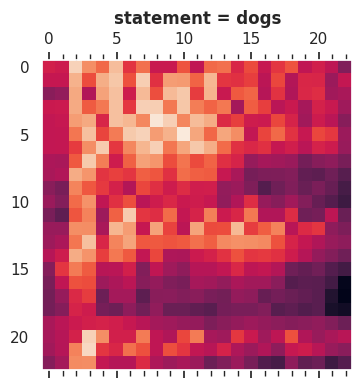

In [126]:
test_track_indx = 80
plt.matshow(STFT[test_track_indx])
plt.grid(ls="")
plt.title(f"statement = {df.statement[test_track_indx]}")

In [119]:
for t in ["syllables_0_2_sc", "syllables_0_2_stft"]:
    np.save(os.path.join(TS_PREPROC_FOLDER, f"{t}.npy"), traces_dict[t])

## Check umap

In [187]:
from umap import UMAP

# Flattens each image
X = STFT.reshape(-1, transf.n_spectral_bins*transf.n_time_bins)
reducer = UMAP(n_neighbors=50, n_jobs=-1)
embedding = reducer.fit_transform(X)

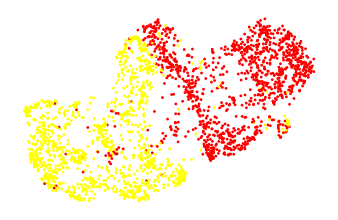

In [188]:
plt.scatter(*embedding.T, c=(df.statement=="dogs"), cmap="autumn", s=1)
plt.axis("off");

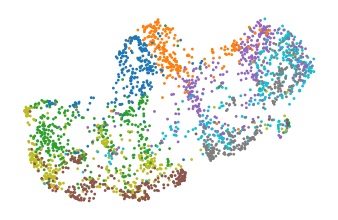

In [189]:
labels = [f"{row.sex}{row.vocal_channel}{row.statement}" for idx, row in df.iterrows()]
labels = pd.Categorical(labels).codes

plt.scatter(*embedding.T, c=labels, cmap="tab10", s=1)
plt.axis("off");